# ERA5 Climate Gridded Data <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ERA5](https://registry.opendata.aws/ecmwf-era5/)

This dataset is external to the Digital Earth Africa platform.

## Background

This notebook uses the ECMWF global climate analysis product called ERA5 from the [AWS Public Dataset Program](https://registry.opendata.aws/ecmwf-era5/). 
This 5th generation operational service utilizes the best available observation data from satellites and in-situ stations, which are assimilated and processed using ECMWF's Integrated Forecast System. The dataset provides essential atmospheric meteorological parameters such as, air temperature, pressure and wind at different altitudes, along with surface parameters like rainfall, and sea parameters like sea-surface temperature and wave height. Spatial resolution is 0.25 degrees (latitude and longitude) which equates to about 31 km. Data is available from 1979 to now.

For offical information on this dataset, see [ERA5 data documentation from ECMWF](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).

The ERA5 data in AWS include 18 surface or single level variables as described [here](https://github.com/planet-os/notebooks/blob/master/aws/era5-pds.md).
This dataset is nominally updated monthly however a delay of a few months has been observed.


## Description

This notebook demonstrates retrieval of ERA5 data using the `load_era5()` wrapper function.

Available variables and names for query are:

| Catagory | Variable | Name for query |
|:--- |:--- |:--- |
| Precipitation | Total precipitation | precipitation_amount_1hour_Accumulation 
| Wind | 10 metre U wind component | eastward_wind_at_10_metres 
| | 10 metre V wind component | northward_wind_at_10_metres
| | 100 metre U wind component | eastward_wind_at_100_metres
| | 100 metre V wind component | northward_wind_at_100_metres
| Temperature | 2 metre temperature | air_temperature_at_2_metres
| | 2 metres maximum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Maximum
| | 2 metres minimum temperature since previous post-processing | air_temperature_at_2_metres_1hour_Minimum
| | 2 metre dew point temperature | dew_point_temperature_at_2_metres
| | Sea surface temperature | sea_surface_temperature
| Air Pressure | Mean sea level pressure | air_pressure_at_mean_sea_level
| | Surface pressure | surface_air_pressure
| Wave | Mean wave period | sea_surface_wave_mean_period
| | Mean direction of waves | sea_surface_wave_from_direction
| | Significant height of combined wind waves and swell | significant_height_of_wind_and_swell_waves
| Snow | Snow density | snow_density
| | Snow depth | lwe_thickness_of_surface_snow_amount
| Solar radiation | Surface solar radiation downwards | integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation

Examples for the following parameters are covered:
1. Daily total precipitation
2. Daily minimum and maximum air temperature at 2 metres height
3. Hourly wind speed at 10 metres height


***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import datacube

import sys
sys.path.append("../Scripts")
from deafrica_load_era5 import load_era5

### Analysis parameters

Define location and time period of interest.
The time period is chosen to be no more than a few months to limit ERA5 data download.

In [2]:
# Define the analysis region (Lat-Lon box)

# Lake Turkana Wind Power Station, Kenya
lat = (2.45, 2.55)
lon = (36.75, 36.85)

# Define the time window
time = '2019-01-01', '2019-03-31'

## Daily total precipitation

Total precipitation is the accumulated liquid and frozen water, comprising rain and snow, that falls to the Earth's surface.
It does not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. 
The units of this parameter are depth in metres of water equivalent. It is the depth the water would have if it were spread evenly over the grid box. 
Care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box.

In this example, total precipitation is aggregated at daily intervals.

In [3]:
var = 'precipitation_amount_1hour_Accumulation'
precip = load_era5(var, lat, lon, time, reduce_func=np.sum, resample='1D', grid='nearest')

In [4]:
# convert to Millimeters (mm), keeping other attributes
attrs = precip[var].attrs
attrs['units']='mm'
precip = precip*1000
precip[var].attrs = attrs

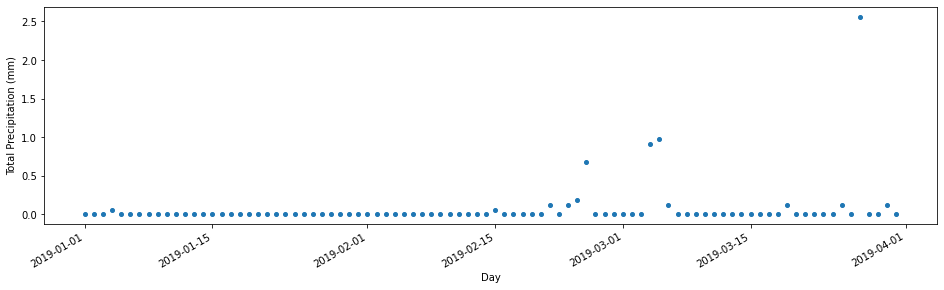

In [5]:
# plot daily total precipitation for this area
precip[var].sum(['lat','lon']).plot(figsize = (16,4), marker='o', markersize=4, linewidth=0);
plt.xlabel('Day');
plt.ylabel('%s (%s)'%('Total Precipitation', precip[var].attrs['units']));

## Daily minimum and maximum air temperature at 2 metres height

Air temperature estimate is provided in kelvin (K) and can be converted to degrees Celsius (°C) by subtracting 273.15.

In this example, highest and lowerest daily temperatures are extracted.

In [6]:
temp_var = 'air_temperature_at_2_metres'
temp_max = load_era5(temp_var, lat, lon, time, reduce_func=np.max, resample='1D', grid='nearest')
temp_min = load_era5(temp_var, lat, lon, time, reduce_func=np.min, resample='1D', grid='nearest')

In [7]:
# convert to Celsius, keeping other attributes
attrs = temp_max.attrs
attrs['units']='C'
temp_max, temp_min = temp_max-273.15, temp_min-273.15
temp_max[temp_var].attrs = attrs
temp_min[temp_var].attrs = attrs

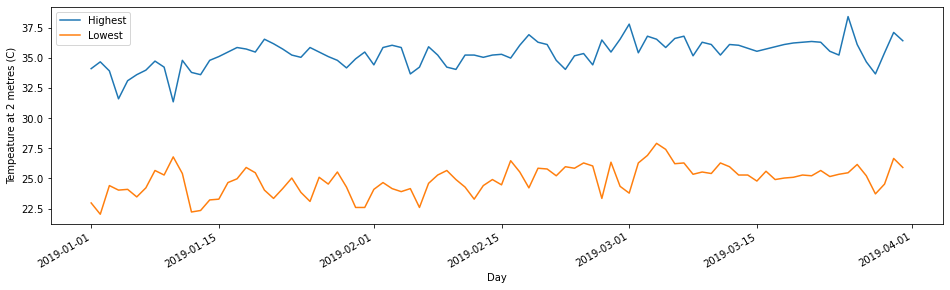

In [8]:
# plot mean temperatures for this area
temp_max[temp_var].mean(['lat','lon']).plot(figsize = (16,4), label='Highest');
temp_min[temp_var].mean(['lat','lon']).plot(label='Lowest');
plt.legend();
plt.xlabel('Day');
plt.ylabel('%s (%s)'%('Tempeature at 2 metres', temp_max[temp_var].attrs['units']));

## Hourly wind speed at 10 metres height

Wind causes changes in surface characteristic of some land cover types, e.g. surface roughness of water. 
Increased surface roughness leads to an increase in measured radar backscatter.
Although typically stronger than wind at surface, wind at 10 metres height may be used to flag windy conditions.

In ERA5, horizontal wind estimate is provided in metres per second and is represented by an eastward component and a northward component. 
A negative sign indicates air moving in the opposite direction, e.g. towards the west for the eastward component.
The two components can be combined to give the speed and direction of the horizontal wind.

Wind speed is highly variable throughout a day, so sampling is kept at hourly.

In [9]:
east = "eastward_wind_at_10_metres"
north = "northward_wind_at_10_metres"

wind_east = load_era5(east, lat, lon, time, reduce_func=np.max, resample='1h', grid='nearest')
wind_north = load_era5(north, lat, lon, time, reduce_func=np.max, resample='1h', grid='nearest')

In [10]:
# combine the two components to get wind speed
wind = (wind_east[east]**2 + wind_north[north]**2)**0.5
wind.attrs['units'] = wind_east[east].attrs['units']

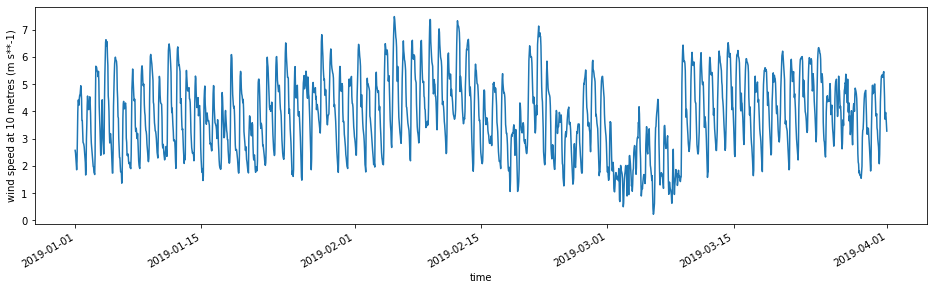

In [11]:
# plot mean wind speed for this area
wind.mean(['lat','lon']).plot(figsize = (16,4));
plt.ylabel('%s (%s)'%('wind speed at 10 metres', wind.attrs['units']));

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.7+262.g1cf3cea8


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)